In [1]:
import torch
import torchvision.models as models
import torch.nn.functional as F
from torch import nn
import math
import os
import numpy as np

In [2]:
import yaml
import argparse
import datetime

from utilities.model_helper import build_model
from utilities.dataloader_helper import build_dataloader
from utilities.optimizer_helper import build_optimizer
from utilities.scheduler_helper import build_lr_scheduler
from utilities.trainer_helper import Trainer
from utilities.tester_helper import Tester
from utilities.utils_helper import create_logger
from utilities.utils_helper import set_random_seed


c:\Users\strom\Desktop\monodle\utilities\datasets\kitti\kitti_eval_python\eval.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_thresholds(scores: np.ndarray, num_gt, num_sample_pts=41):


>>CONFIG

In [3]:
cfg = {
    'random_seed': 444,
    'dataset': {
        'type': 'KITTI',
        'batch_size': 1,
        'use_3d_center': True,
        'class_merging': False,
        'use_dontcare': False,
        'bbox2d_type': 'anno',
        'meanshape': False,
        'writelist': ['Car'],
        'random_flip': 0.5,
        'random_crop': 0.5,
        'scale': 0.4,
        'shift': 0.1
    },
    'model': {
        'type': 'centernet3d',
        'backbone': 'dla34',
        'neck': 'DLAUp',
        'num_class': 3
    },
    'optimizer': {
        'type': 'adam',
        'lr': 0.00125,
        'weight_decay': 1e-05
    },
    'lr_scheduler': {
        'warmup': True,
        'decay_rate': 0.1,
        'decay_list': [90, 120]
    },
    'trainer': {
        'max_epoch': 140,
        'gpu_ids': '0',
        'save_frequency': 10
    },
    'tester': {
        'type': 'KITTI',
        'mode': 'single',
        'checkpoint': '/Users/strom/Desktop/monodle/utilities/checkpoints/checkpoint_epoch_140.pth',
        'checkpoints_dir': 'checkpoints',
        'threshold': 0.2
    },
    'evaluate': True,
}

>> TOTAL CENTER NET MODEL

In [4]:
train_loader, test_loader  = build_dataloader(cfg['dataset'])

In [5]:
log_file = 'train.log.%s' % datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
logger = create_logger(log_file)

In [6]:
model = build_model(cfg['model'])
print(model)

CenterNet3D(
  (backbone): DLA(
    (base_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level0): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (level2): Tree(
      (tree1): BasicBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
#  build optimizer
optimizer = build_optimizer(cfg['optimizer'], model)

# build lr scheduler
lr_scheduler, warmup_lr_scheduler = build_lr_scheduler(cfg['lr_scheduler'], optimizer, last_epoch=-1)

In [8]:
logger.info('###################  Training  ##################')
logger.info('Batch Size: %d'  % (cfg['dataset']['batch_size']))
logger.info('Learning Rate: %f'  % (cfg['optimizer']['lr']))
trainer = Trainer(cfg=cfg['trainer'],
                    model=model,
                    optimizer=optimizer,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    lr_scheduler=lr_scheduler,
                    warmup_lr_scheduler=warmup_lr_scheduler,
                    logger=logger)
trainer.train()

2023-05-18 13:10:04,199   INFO  ###################  Training  ##################
2023-05-18 13:10:04,200   INFO  Batch Size: 1
2023-05-18 13:10:04,201   INFO  Learning Rate: 0.001250
epochs:   0%|          | 0/140 [00:00<?, ?it/s]

voici input :
torch.Size([1, 3, 96, 320]) torch.Size([1, 50, 2]) torch.Size([1, 50, 2]) torch.Size([1, 50, 1]) torch.Size([1, 50, 2]) torch.Size([1, 50, 3])
voici output :
torch.Size([1, 3, 96, 320]) torch.Size([1, 2, 96, 320]) torch.Size([1, 2, 96, 320]) torch.Size([1, 2, 96, 320]) torch.Size([1, 2, 96, 320]) torch.Size([1, 3, 96, 320]) torch.Size([1, 24, 96, 320])
tensor([[[[ 6.5101e-05,  1.5126e-04,  1.9767e-04,  ..., -1.3932e-04,
            1.0917e-05,  7.8677e-05],
          [ 9.1439e-05,  2.0010e-04,  1.5284e-04,  ..., -1.1737e-04,
           -9.8029e-05,  1.1919e-04],
          [ 1.3156e-05,  2.0801e-04,  1.2759e-04,  ..., -2.9315e-04,
            2.1590e-05,  2.8814e-04],
          ...,
          [ 4.5947e-05,  1.6975e-04,  2.8990e-04,  ...,  1.9433e-04,
            1.1867e-04,  1.9205e-04],
          [ 1.8824e-05,  2.4370e-04,  3.6438e-04,  ...,  6.3804e-05,
            1.3786e-04,  2.0628e-04],
          [ 1.0526e-04,  1.2010e-04,  2.2952e-05,  ...,  1.4812e-04,
            

c:\Users\strom\Desktop\monodle\utilities\loss\centernet_loss.py:108: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  return input[mask]  # B*K*C --> M * C
c:\Users\strom\Desktop\monodle\utilities\loss\centernet_loss.py:111: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  return target[mask]
c:\Users\strom\Desktop\monodle\utilities\loss\centernet_loss.py:89: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  heading_input_cls, heading_t

KeyboardInterrupt: 

In [8]:
if cfg['evaluate']:
        tester = Tester(cfg=cfg['tester'],
                        model=model,
                        dataloader=test_loader,
                        logger=logger)
        tester.test()

2023-05-18 13:53:48,090   INFO  ==> Done
Evaluation Progress: 100%|██████████| 3769/3769 [02:16<00:00, 27.69it/s]
2023-05-18 13:56:04,234   INFO  ==> Saving ...
2023-05-18 13:56:06,212   INFO  ==> Loading detections and GTs...
2023-05-18 13:56:07,167   INFO  ==> Evaluating (official) ...
c:\Users\strom\anaconda3\envs\PyTorch\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 36 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\strom\anaconda3\envs\PyTorch\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 50 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\strom\anaconda3\envs\PyTorch\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\strom\anaconda3\envs\

Car 0.0 0 1.77 412.13 159.67 537.06 263.34 1.85 1.69 4.28 -2.68 1.61 15.01 1.60 7.79
Car 0.0 0 -2.65 52.78 170.23 391.78 283.83 1.47 1.66 4.37 -5.96 1.49 11.13 -3.13 5.78
Car 0.0 0 -1.71 706.00 158.71 824.12 262.23 1.77 1.60 3.68 2.83 1.53 14.00 -1.51 6.56
Car 0.0 0 1.64 508.32 171.69 571.21 227.36 1.57 1.60 3.81 -2.16 1.55 22.45 1.55 5.09
Car 0.0 0 -1.00 591.14 167.16 646.69 193.87 1.50 1.57 3.52 0.52 1.19 42.79 -0.99 1.00
Car 0.0 0 1.62 530.03 169.33 583.20 212.39 1.47 1.67 4.25 -2.09 1.40 28.32 1.54 1.52


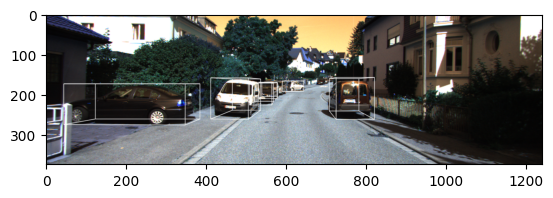

In [8]:
import cv2
from utilities.datasets.kitti.kitti_utils import Calibration, Object3d
from utilities.datasets.utils import draw_projected_box3d
import matplotlib.pyplot as plt


file_path = '/Users/strom/Desktop/monodle/outputs/data/006372.txt'  # Replace with the actual path to your .txt file

image_path = "/Users/strom/Desktop/monodle/data/KITTI/object/training/image_2/006372.png"
path = "/Users/strom/Desktop/monodle/data/KITTI/object/training/calib/006372.txt"
image = cv2.imread(image_path)

with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace and newline characters
        # Process each line here
        print(line)
        test_obj = Object3d(line)
        calib_3D = Calibration(path)
        _ , boxes_corner = calib_3D.corners3d_to_img_boxes(np.resize(test_obj.generate_corners3d(),(1,8,3)))
        boxes = np.resize(boxes_corner,(8,2))[::-1]
        image = draw_projected_box3d(image, boxes, color=(255, 255, 255), thickness=1)

plt.imshow(image)
plt.show()
        